# Tutorial
This is a simply and concise tutorial to start using SimSpread, using as example dataset the classical "Iris"
dataset proposed by R.A. Fisher.

First, we must install the necesary packages we will use in this tutorial:

In [1]:
import Pkg; Pkg.add(["MLDatasets", "NamedArrays", "Distances", "DataFrames", "AlgebraOfGraphics", "CairoMakie"])
Pkg.add(url="https://github.com/cvigilv/SimSpread.jl.git", rev = "develop")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
    Updating git-repo `https://github.com/cvigilv/SimSpread.jl.git`
   Resolving package versions...
    Updating `~/.julia/environments/v1.8/Project.toml`
  [afa5cc60] ~ SimSpread v0.1.0 `https://github.com/cvigilv/SimSpread.jl.git#main` ⇒ v0.1.0 `https://github.com/cvigilv/SimSpread.jl.git#develop`
    Updating `~/.julia/environments/v1.8/Manifest.toml`
  [afa5cc60] ~ SimSpread v0.1.0 `https://github.com/cvigilv/SimSpread.jl.git#main` ⇒ v0.1.0 `https://github.com/cvigilv/SimSpread.jl.git#develop`
Precompiling project...
  ✓ SimSpread
  1 dependency successfully precompiled in 7 seconds. 397 already precompiled.


After the above command complete, go ahead and load the dataset we will use.

In [2]:
using MLDatasets, DataFrames

# Load Iris dataset
iris = Iris().dataframe
first(iris, 5)

Row,sepallength,sepalwidth,petallength,petalwidth,class
,Float64,Float64,Float64,Float64,String15
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa


Since this is a multi-class problem, we need to convert the single column of `class`
into 3 distinct columns corresponding to each of the classes in the dataset. For this,
we can one-hot encode over each row using the following transformation:

In [3]:
transform!(
    iris, 
    :class => ByRow(c -> c .== "Iris-setosa") => "Is Iris-setosa?",
    :class => ByRow(c -> c .== "Iris-versicolor") => "Is Iris-versicolor?",
    :class => ByRow(c -> c .== "Iris-virginica") => "Is Iris-virginica?",
)
first(iris, 5)

Row,sepallength,sepalwidth,petallength,petalwidth,class,Is Iris-setosa?,Is Iris-versicolor?,Is Iris-virginica?
,Float64,Float64,Float64,Float64,String15,Bool,Bool,Bool
1,5.1,3.5,1.4,0.2,Iris-setosa,true,false,false
2,4.9,3.0,1.4,0.2,Iris-setosa,true,false,false
3,4.7,3.2,1.3,0.2,Iris-setosa,true,false,false
4,4.6,3.1,1.5,0.2,Iris-setosa,true,false,false
5,5.0,3.6,1.4,0.2,Iris-setosa,true,false,false


## Data splitting

To assess the performance of SimSpread, we will split the iris dataset in 2 groups:
training set, which will correspond to 80% of the data, and testing set, which will
correspond to the remaining 20%. 

We will shuffle and split the dataset with the following code:

In [4]:
using Random

# Split dataset
Random.seed!(1)
N = nrow(iris)
perm = randperm(N)

train_idx = last(perm, Int(0.8*N))
test_idx  = first(perm, Int(0.2*N))

Xtrain = iris[train_idx, ["sepallength", "sepalwidth", "petallength", "petalwidth"]]
Xtest  = iris[test_idx,  ["sepallength", "sepalwidth", "petallength", "petalwidth"]]
ytrain = iris[train_idx, ["Is Iris-setosa?", "Is Iris-versicolor?", "Is Iris-virginica?"]]
ytest  = iris[test_idx,  ["Is Iris-setosa?", "Is Iris-versicolor?", "Is Iris-virginica?"]]

display(first(Xtrain, 5))
display(first(ytrain, 5))

Row,sepallength,sepalwidth,petallength,petalwidth
,Float64,Float64,Float64,Float64
1,6.7,3.3,5.7,2.1
2,5.4,3.9,1.7,0.4
3,7.4,2.8,6.1,1.9
4,5.5,3.5,1.3,0.2
5,4.9,3.0,1.4,0.2


Row,Is Iris-setosa?,Is Iris-versicolor?,Is Iris-virginica?
,Bool,Bool,Bool
1,false,false,true
2,true,false,false
3,false,false,true
4,true,false,false
5,true,false,false


## Meta-description preparation

SimSpread works using a meta-description of the query nodes 

In [5]:
using Distances, NamedArrays

# Calculate pairwise similarity using features
# Note: Here we use Jaccard to bound the similarity between 0 (completely disimmilar) 
#       to 1 (completely similar). For more distance and similarity measurements, please
#       refer to https://github.com/JuliaStats/Distances.jl
Dtrain = 1 .- pairwise(Jaccard(), Matrix(Xtrain), dims = 1)
Dtest = 1 .- pairwise(Jaccard(), Matrix(Xtest), Matrix(Xtrain), dims = 1)

# Convert to NamedArray
Dtrain = NamedArray(Dtrain, (["E$i" for i in train_idx], ["E$i" for i in train_idx]))
Dtest = NamedArray(Dtest, (["E$i" for i in test_idx], ["E$i" for i in train_idx]));

In [6]:
using SimSpread

# Generate meta-description from similarity measurements
α = 0.9
Xtrain′ = featurize(Dtrain, α, true)
Xtest′ = featurize(Dtest, α, true)

# Convert data
ytrain′ = NamedArray(Matrix{Float64}(ytrain), (["E$i" for i in train_idx], ["C$i" for i in 1:3]))
ytest′ = NamedArray(Matrix{Float64}(ytest), (["E$i" for i in test_idx], ["C$i" for i in 1:3]))

# Construct feature-source-target graph for predictions
G = construct(ytrain′, ytest′, Xtrain′, Xtest′);

## Predicting labels with SimSpread



In [7]:
# Predict
ŷtrain = predict(G, ytrain′)
ŷtest = predict(G, ytest′)

ŷtest[1:3, :]

3×3 Named Matrix{Float64}
A ╲ B │       C1        C2        C3
──────┼─────────────────────────────
E133  │      0.0  0.132744  0.795833
E3    │ 0.891969       0.0       0.0
E43   │ 0.633814       0.0       0.0

As we can see, we predict the probability for each class of flower possible. To evaluate the predictive performance as a multiclass problem, we will assign the label with the highest score as the predicted label.
> In the example above, the predicted labels for each row in the matrix would be "Iris-virginica" (C3), "Iris-setosa" (C1) & "Iris-setosa" (C1). 

To convert the problem from single-class to multi-class we do the following:

In [8]:
# Convert continuous prediction to predicted label using maximum score
class_mapper = ["Iris-setosa", "Iris-versicolor", "Iris-virginica"]

ŷ = hcat(
    vcat(test_idx, train_idx), 
    vcat(
        [class_mapper[cidx] for (_, cidx) in Tuple.(argmax(ŷtest, dims=2))], 
        [class_mapper[cidx] for (_, cidx) in Tuple.(argmax(ŷtrain, dims=2))]
        )
)

first(ŷ[:,2], 3)

3-element Vector{Any}:
 "Iris-virginica"
 "Iris-setosa"
 "Iris-setosa"

Great! Our predicted labels match what we expected. Now let's assess how good is SimSpread in predicting
the classes for the iris dataset.

## Assesing predictive performance



In order to have an idea of the predictive performance of the model we constructed, we will use
two common metrics in multi-class prediction problems to evaluate the predictions for both the 
training and testing sets: 
    
1. _Accuracy_, that indicates how close a given set of predictions are to their true value, and
2. _Error rate_, that indicates the inverse of accuracy.

Let's start with accuracy:

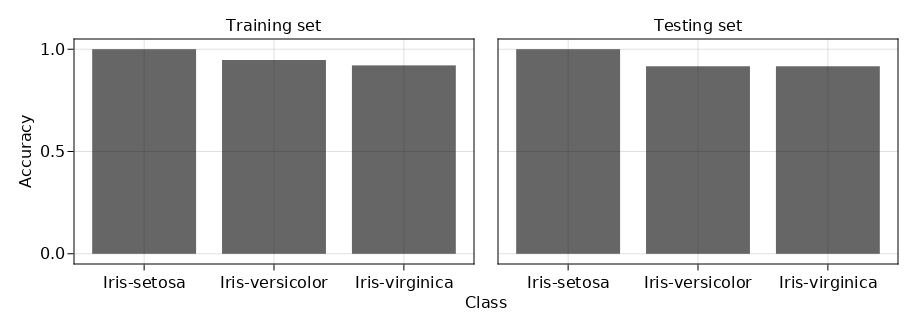

In [9]:
using AlgebraOfGraphics, CairoMakie

# Evaluate predictions
plt = data(
    (
        train = [Bool(i ∈ train_idx) for i in 1:N],
        y = iris[!, "class"],
        yhat = ŷ[sortperm(ŷ[:,1]),2]
    )
)
plt *= expectation()
plt *= mapping(
    :y => "Class",   
    (:y, :yhat) => isequal => "Accuracy"
)
plt *= mapping(col = :train => renamer(true => "Training set", false => "Testing set") => "Dataset")

draw(plt; axis = (width = 400, height = 225))

As we can see, our proposed SimSpread model achieves high accuracy for both training and testing sets.

Let's see the error rates for the same grouping:

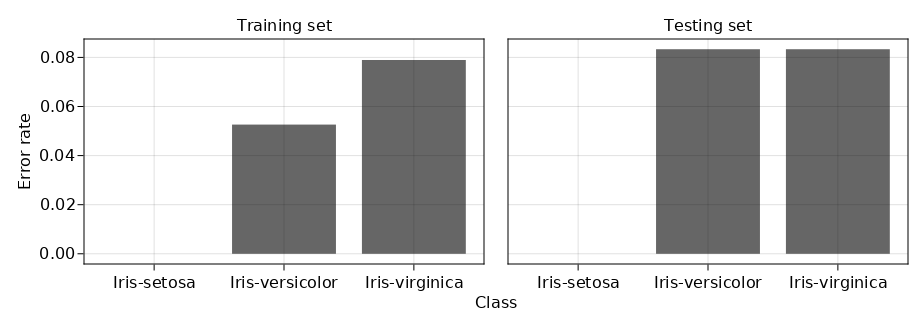

In [10]:
plt = data(
    (
        train = [Bool(i ∈ train_idx) for i in 1:N],
        y = iris[!, "class"],
        yhat = ŷ[sortperm(ŷ[:,1]),2]
    )
)
plt *= expectation()
plt *= mapping(
    :y => "Class",   
    (:y, :yhat) => !isequal => "Error rate"
)
plt *= mapping(col = :train => renamer(true => "Training set", false => "Testing set") => "Dataset")

draw(plt; axis = (width = 400, height = 225))

Here we also see goo performance, achieving low error rate for all the classes in both the training and 
testing sets. We also can appreciate that the the testing set present a higher mean error rate than the
training set.

Let's visualize where the predicted classes fall in our training and testing sets. First, lets see our
ground truth:

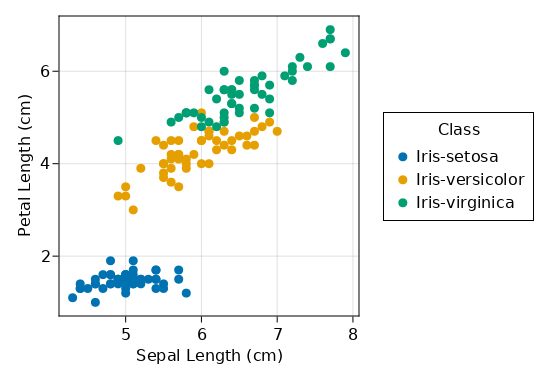

In [11]:
plt = data(
    (
        sepallength = iris[!, "sepallength"],
        petallength = iris[!, "petallength"],
        y = iris[!, "class"],
    )
)
plt *= mapping(
    :sepallength => "Sepal Length (cm)", 
    :petallength => "Petal Length (cm)", 
    color=:y => "Class"
)
draw(plt; axis = (width = 300, height = 300))

We can clearly see that _setosa_ plants are completely separated from the rest of
the plants in the dataset. _Versicolor_ and _virginica_ present some overlap, which
might respond to what we have see in the predictive performance.

Let's visualize the prediction over this scatter plot to map where are the incorrect
predictions:

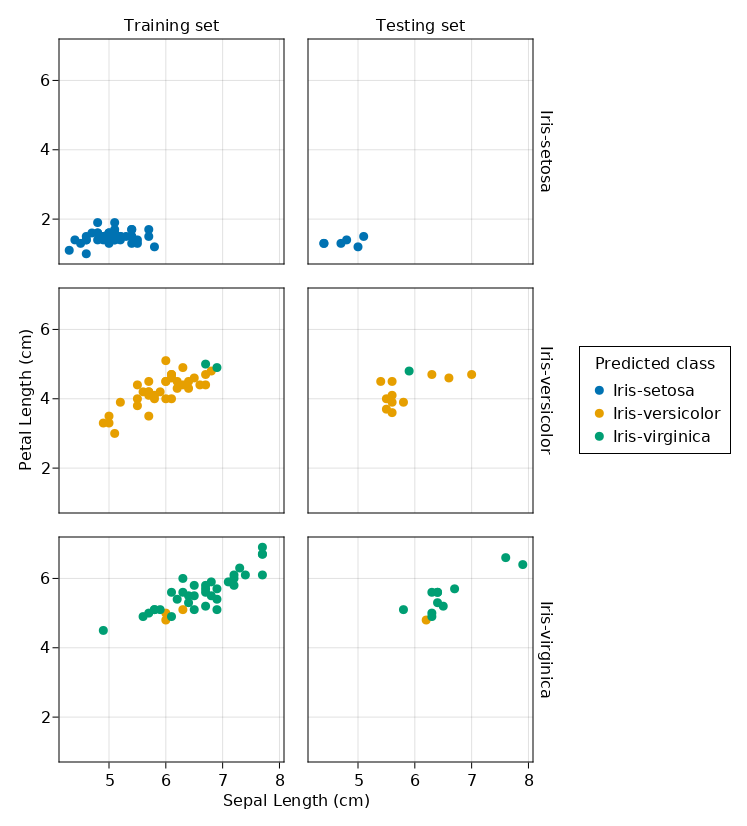

In [12]:
plt = data(
    (
        sepallength = iris[!, "sepallength"],
        petallength = iris[!, "petallength"],
        train = [Bool(i ∈ train_idx) for i in 1:N],
        y = iris[!, "class"],
        yhat = ŷ[sortperm(ŷ[:,1]),2]
    )
)
plt *= mapping(
    :sepallength => "Sepal Length (cm)", 
    :petallength => "Petal Length (cm)", 
    col = :train => renamer(true => "Training set", false => "Testing set") => "Dataset", 
    row =:y => "Class", 
    color=:yhat => "Predicted class"
)

draw(plt; axis = (width = 225, height = 225))